# 0.0 IMPORTS

In [131]:
import requests
import pandas           as pd
import pandas_ta        as pd_ta
import numpy            as np
import seaborn          as sns
import yfinance         as yfin #workaround as pandas_datareader is not working on yahoo today
yfin.pdr_override()
import matplotlib.pyplot as plt

from datetime                   import date, timedelta
from bs4                        import BeautifulSoup
from pandas_datareader          import data as pdr
from sklearn.linear_model       import LinearRegression 
from sklearn.model_selection    import train_test_split
from sklearn.metrics            import mean_squared_error, r2_score, mean_absolute_error

Caso use Anaconda e enfrente o problema SSL ao rodar o código, a solução pode ser encontrada abaixo:

https://github.com/conda/conda/issues/8273

# 1.0 Fundos de Investimento Imobiliário (FII)

## 1.1 Carregando dados

In [2]:
url = "https://www.fundsexplorer.com.br/ranking"
r = requests.get(url)
df_list = pd.read_html(r.text)
df = df_list[0]
df.shape


(250, 26)

## 1.2 Dimensões de dados

In [3]:
print(f'Total de linhas: {df.shape[0]}')
print(f'Total de colunas: {df.shape[1]}')

Total de linhas: 250
Total de colunas: 26


## 1.3 Tipo dos dados

In [4]:
df.dtypes

Códigodo fundo              object
Setor                       object
Preço Atual                 object
Liquidez Diária            float64
Dividendo                   object
DividendYield               object
DY (3M)Acumulado            object
DY (6M)Acumulado            object
DY (12M)Acumulado           object
DY (3M)Média                object
DY (6M)Média                object
DY (12M)Média               object
DY Ano                      object
Variação Preço              object
Rentab.Período              object
Rentab.Acumulada            object
PatrimônioLíq.              object
VPA                         object
P/VPA                      float64
DYPatrimonial               object
VariaçãoPatrimonial         object
Rentab. Patr.no Período     object
Rentab. Patr.Acumulada      object
VacânciaFísica              object
VacânciaFinanceira          object
QuantidadeAtivos             int64
dtype: object

## 1.4 Verificando e subtituindo NA

In [5]:
# Verificar quantas colunas possuem dados nulos
df.isnull().sum()

Códigodo fundo               0
Setor                        0
Preço Atual                  7
Liquidez Diária              7
Dividendo                    0
DividendYield               12
DY (3M)Acumulado            12
DY (6M)Acumulado            12
DY (12M)Acumulado           12
DY (3M)Média                12
DY (6M)Média                12
DY (12M)Média               12
DY Ano                      23
Variação Preço              12
Rentab.Período              12
Rentab.Acumulada            12
PatrimônioLíq.               0
VPA                          0
P/VPA                        7
DYPatrimonial               47
VariaçãoPatrimonial         47
Rentab. Patr.no Período     47
Rentab. Patr.Acumulada      47
VacânciaFísica             130
VacânciaFinanceira         224
QuantidadeAtivos             0
dtype: int64

In [6]:
df = df.replace(np.nan,0)

## 1.5 Selecionando colunas

In [7]:

df = df.drop(columns=['DYPatrimonial','VariaçãoPatrimonial','Rentab. Patr.no Período',
                    'Rentab. Patr.Acumulada','VacânciaFinanceira','DY Ano','DividendYield','DY (3M)Média','DY (6M)Média',
                    'DY (3M)Acumulado',	'DY (6M)Acumulado','DY (12M)Acumulado','DY (12M)Média'])

In [8]:
dfColunas = []
naoNumColunas = ['Códigodo fundo','Setor']
for coluna in df:
    if coluna in naoNumColunas:
        pass
    else:
        dfColunas.append(coluna)       

## 1.6 Tratamento de dados

In [9]:
for colunas in dfColunas:
    df[colunas] = [str(x).replace("R$ ","").replace("%","").replace(".","").replace(",",".") for x in df[colunas]]
    df[colunas] = [pd.to_numeric(x) for x in df[colunas]]

In [10]:
# Ajustando VPA para as cadas decimais corretas
df['P/VPA'] = df['P/VPA'] / 1000

## 1.7 Filtrando variáveis

In [11]:
def filtroDF(quantidadeAtivos=9, liquidezDiaria=1000,PVPA=1.2,VacânciaFísica=10):
# Filtrando para tirar FII's com alto risco
        # Com mais de 5 ativos. Casos menores do que esse aumentam o risco pela baixa pulverização
        dataFrame = df[(df['QuantidadeAtivos'] > quantidadeAtivos) & 
        # Liquidez diária superior a 1000
                (df['Liquidez Diária'] > liquidezDiaria) &
        # P/VPA até Máximo 1,2 (20% a mais do que o patrimonio)
                (df['P/VPA'] < PVPA) &
        # Vacância inferior a 10% do território
                (df['VacânciaFísica'] < VacânciaFísica)]
        return dataFrame
        
df = filtroDF()

In [12]:
testing = []
listingCarlos = ['BTLG11','HGRY11','VILG11','HSML11','HGBS11','XPML11','KNRI11','HGRE11','HGLG11']
for i in df['Códigodo fundo']:
    if i in listingCarlos:
        testing.append(i)
testing        

['KNRI11', 'HGBS11', 'VILG11', 'HGLG11', 'BTLG11', 'XPML11']

In [13]:
# Ordernar por critérios de maior importância (na minha opinião)
df = df.sort_values(by=['PatrimônioLíq.'], ascending = False)

# Formatar para remover Notação Científica do Patrimônio Líquido
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
df

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
84,KNRI11,Híbrido,142.35,249070,0.77,3.40,3.94,-3.99,"3,800,803,257.11",157.34,0.90,3.35,20
163,HGLG11,Logística,167.51,433700,1.10,1.35,2.02,-2.84,"3,151,358,842.72",147.86,1.13,6.30,17
113,HGRU11,Híbrido,114.00,375980,0.72,-3.13,-2.51,-7.36,"2,163,602,469.79",117.55,0.97,0.00,16
87,HGBS11,Shoppings,189.32,196470,0.85,-3.29,-2.84,-13.48,"2,143,980,697.65",214.40,0.88,7.10,17
247,XPML11,Shoppings,101.81,699970,0.57,-1.27,-0.72,-7.28,"1,900,090,443.88",104.36,0.98,4.60,13
110,VILG11,Logística,102.58,394390,0.64,-0.83,-0.23,-8.67,"1,708,615,548.48",113.93,0.90,0.00,15
103,VISC11,Shoppings,105.35,263140,0.58,0.59,1.16,-8.90,"1,702,561,351.78",119.30,0.88,8.10,15
102,BRCO11,Logística,99.20,436720,0.57,-3.48,-2.92,-9.47,"1,603,955,235.27",108.53,0.91,0.00,10
77,BBPO11,Lajes Corporativas,92.00,263620,0.82,-15.18,-14.46,-7.83,"1,526,344,263.71",95.88,0.96,0.00,64
242,BTLG11,Logística,107.10,396070,0.72,1.37,2.05,-4.50,"1,516,402,298.06",99.57,1.08,0.00,16


In [14]:
df['Setor'].value_counts()

Logística             7
Outros                6
Shoppings             4
Híbrido               3
Lajes Corporativas    1
Name: Setor, dtype: int64

# 2.0 AÇÕES

## 2.1 Carregando dados

In [285]:
# Cotação de cada empresa
df_ibov = pdr.get_data_yahoo("PSSA3.SA", start="2018-01-01", end=(date.today() + timedelta(days=-1) ))


[*********************100%***********************]  1 of 1 completed


## 2.2 Selecionando colunas

In [286]:
df_ibov = df_ibov[['Open','Close','Volume']]
df1 = df_ibov.copy()

In [287]:
df1.isnull().sum()

Open      0
Close     0
Volume    0
dtype: int64

## 2.3 Tratamento de Dados

In [288]:
df1['MA_200'] = df1['Close'].rolling( window = 200).mean()
df1['EMA_8'] = df1.ta.ema( close='Close', length= 8, append = True)
# df1['EMA_21'] = df1.ta.ema( close='Close', length= 8, append = True)
df1['MA_200'] = df1['MA_200'].fillna(0)
df1['Volume'] = df1['Volume'].astype(int)
df1 = df1.reset_index()
df1 = df1.iloc[200:]


In [289]:
df1.dtypes

Date      datetime64[ns]
Open             float64
Close            float64
Volume             int32
MA_200           float64
EMA_8            float64
dtype: object

<AxesSubplot:>

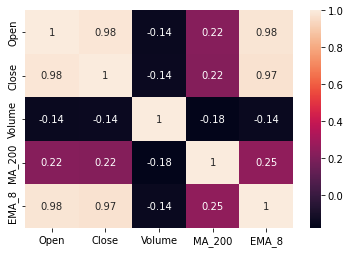

In [290]:
corr = df1.corr()
sns.heatmap(corr, annot=True)

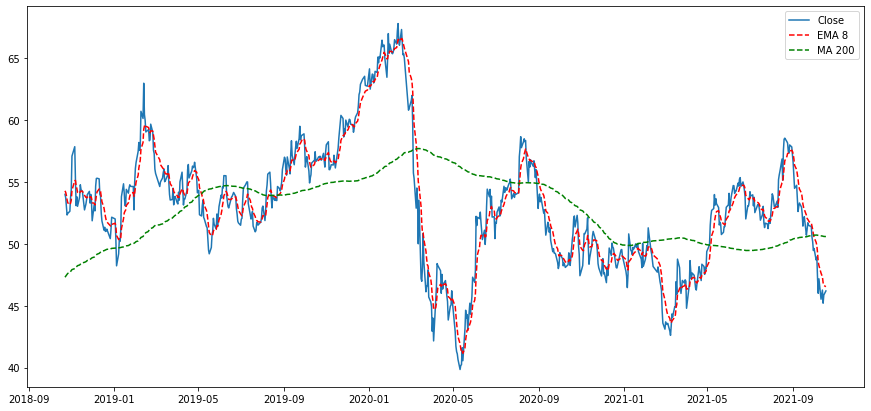

In [291]:
plt.figure(figsize=(15,7))
plt.plot(df1['Date'], df1['Close'], label='Close')
plt.plot(df1['Date'], df1['EMA_8'], 'r--', label='EMA 8')
# plt.plot(df1['Date'], df1['EMA_21'], 'b--', label='EMA 21')
plt.plot(df1['Date'], df1['MA_200'], 'g--', label='MA 200')
plt.legend()
plt.show()

## 1.2 Divisão do período treino e teste

In [292]:
X_train, X_test, y_train, y_test = train_test_split( df1[['Close']], df1[['Open','Volume','EMA_8','MA_200']], test_size= .2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(588, 1) (147, 1) (588, 4) (147, 4)


In [293]:
len(y_pred)

147

In [294]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.47950180004827136

In [295]:
print("Model Coefficients:", lr.coef_)
print("Mean Absolute Error:", mean_absolute_error( y_test, y_pred ))
print("Coefficient of Determination:", r2_score( y_test, y_pred))

Model Coefficients: [[ 9.68941257e-01]
 [-2.30127837e+04]
 [ 9.28573976e-01]
 [ 1.07524185e-01]]
Mean Absolute Error: 87682.12129530567
Coefficient of Determination: 0.47950180004827136
